In this notebook I am going to present tree based algorithms (xgboost[link], lightgbm[link], catboost[link]) and hyperparameter tuning in LightGBM as an example library to show how it works. The idea of chosing LightGBM is that it is being well-known for winning solutions on kaggle[link].

All three libraries are gradient boosting frameworks which uses decision trees. Some of them have parameter to precise the type of booster. For instance, LGBM has gbdt (gradient boosting decision tree), rf (random forest), dart (Dropouts meet Multiple Additive Regression Trees) and goss (Gradient-based One-Side Sampling).

The main difference between LightGBM and other decision-tree frameworks is that it grows tree vertically while other algorithms grows trees horizontally. In the first picture you can see how **Light GBM** grows tree **leaf-wise** and second picture shows how algorithms grows **level-wise**. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

<img src="img/tree.png" title="LightGBM's tree structure" height="500" width="500" />
<img src="img/other_tree.png" title="Other frameworks tree structure" height="500" width="500" />

Among other differences, xgboost doesn't support categorical features in comparison to LGBM or catboost. In other words, xgboost accepts only numerical values [https://stackoverflow.com/a/34346937].
The only difficulties about using these libraries are parameter tuning. 

There are four approaches to tuning the hyperparameters of a machine learning model

1. **Manual**: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results.

2. **Grid Search**: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!

3. **Random search**: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.

4. **Automated Hyperparameter Tuning**: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.

Hyperparameter optimization software
- Hyperopt (Distributed Asynchronous Hyper-parameter Optimization)
- Scikit-optimize (Sequential model-based optimization with a `scipy.optimize` interface )
- Spearmint (Spearmint Bayesian optimization codebase from Harvard Intelligent Probabilistic Systems Group, outdated, but still popular)
- GPyOpt (`Gaussian Process Optimization using GPy` from Sheffield Machine Learning Software, Department of Computer Science, The University of Sheffield) - very powerfull approach
- RoBo (`RoBO: a Robust Bayesian Optimization framework` from AutoML-Freiburg, Germany) - very powerfull as well
- SMAC3 (`Sequential Model-based Algorithm Configuration` aslo from AutoML-Freiburg, Germany)

There are 3 cases if you apply hyperparameter optimization:
1. Underfitting (it can't even learn the train set)
2. Good fitting (somewhere between underfitting and overfitting)
3. Overfitting (model is so powerful that it just overfits the train set and can not generalize it at all)

We should try to understand that if model is underfitting or overfitting.

Divide hyperparameters into two group.

1. In red group we have the parmeters that constraint the model. If we have larger value of the parameter the heavier the constraint is 
    
    (**overfitting -> underfitting**):
   - Increasing it impedes fitting
   - Increase it to reduce overfitting
   - Decrease to allow model fit easier
2. In the green group the highier the value, the more powerful the model
    
     (**underfitting -> overfitting**):
   - Increasing it leads to a better fit (overfit) on train set
   - Increase it, if model underfits
   - Decrease if overfits

In [1]:
# !pip install pandas lightgbm shap gc scikit-plot scikit-learn matplotlib hyperopt seaborn wordcloud missingno plotly yellowbrick eli5

In [2]:
# HYPER PARAMS
max_boosting_rounds = 4000

import time
notebookstart= time.time()

import datetime
import pandas as pd
import numpy as np
import random
import time

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from wordcloud import WordCloud
import missingno as mn
from yellowbrick.text import TSNEVisualizer
import plotly
plotly.tools.set_credentials_file(username='b5y', api_key='ZHRPWK21a22nkLu4XEkK')

# Hide Warnings
Warning = True
if Warning is False:
    import warnings
    warnings.filterwarnings(action='ignore')
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)

# Modeling..
import eli5
import lightgbm as lgb
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
import scikitplot as skplt
from sklearn import preprocessing

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix

np.random.seed(2018)

from contextlib import contextmanager
import re
import string
import gc

In [3]:
@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

# Data Visualization
def cloud(text, title, size = (10,7)):
    # Processing Text
    wordcloud = WordCloud(width=800, height=400,
                          collocations=False
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=25,color='w')
    plt.tight_layout(pad=0)
    plt.show()

In [4]:
DIR = "/l/musaevm1/data/quora_FILES"
embeddings = "/embeddings"

In [5]:
train = DIR + "/train.csv"
test = DIR + "/test.csv"

In [6]:
train = pd.read_csv(train, index_col= 'qid').sample(50000)
test = pd.read_csv(test, index_col= 'qid').sample(5000)
testdex = test.index

target_names = ["Sincere","Insincere"]
y = train['target'].copy()

In [7]:
print(train.shape)
train.head()

(50000, 2)


,question_text,target
qid,,
d61b098340966d9d6501,What is the physical peak a human can achieve?,0
c8d5c445fce3c312ca5f,What is the society like in United Kingdom?,0
9177e73a312fb5ff9e43,How should I deal with flight instructors who ...,0
1ffecf3a38aa5062f51c,Can you take credit for subconscious acts? And...,0
daaea60735fcb5f49b12,What master programs are taught in English in ...,0


In [8]:
print("Class Balance..")
train.target.value_counts(normalize=True)

Class Balance..


0    0.93822
1    0.06178
Name: target, dtype: float64

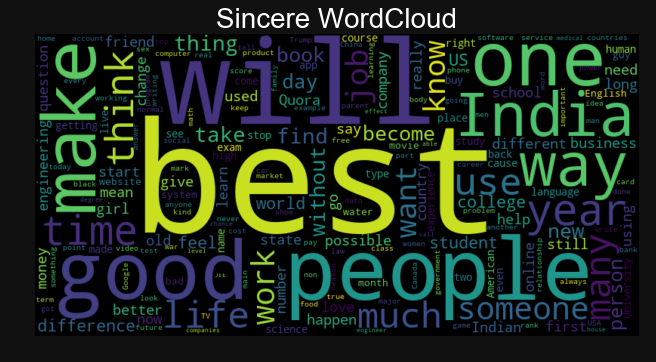

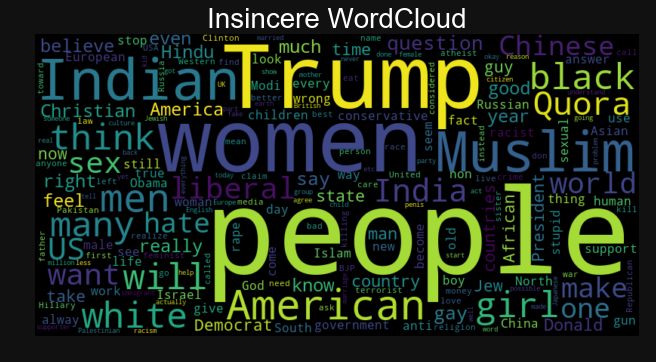

In [9]:
for i,name in [(0,"Sincere"),(1,"Insincere")]:
     cloud(train.loc[train.target == i,"question_text"], title="{} WordCloud".format(name), size=[8,5])

In [10]:
###########################################################################################
### Upvote this :) - https://www.kaggle.com/ogrellier/lgbm-with-words-and-chars-n-gram ####
###########################################################################################

# The better written the code, the easier the copy pasta

# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def get_indicators_and_clean_comments(df, text_var):
    """
    Check all sorts of content as it may help find toxic comment
    Though I'm not sure all of them improve scores
    """
    # Count number of \n
    df["ant_slash_n"] = df[text_var].apply(lambda x: count_regexp_occ(r"\n", x))
    # Get length in words and characters
    df["raw_word_len"] = df[text_var].apply(lambda x: len(x.split()))
    df["raw_char_len"] = df[text_var].apply(lambda x: len(x))
    # Check number of upper case, if you're angry you may write in upper case
    df["nb_upper"] = df[text_var].apply(lambda x: count_regexp_occ(r"[A-Z]", x))
    # Number of F words - f..k contains folk, fork,
    df["nb_fk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ff]\S{2}[Kk]", x))
    # Number of S word
    df["nb_sk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    # Number of D words
    df["nb_dk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    # Number of occurence of You, insulting someone usually needs someone called : you
    df["nb_you"] = df[text_var].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x))
    # Just to check you really refered to my mother ;-)
    df["nb_mother"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    # Just checking for toxic 19th century vocabulary
    df["nb_ng"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    # Some Sentences start with a <:> so it may help
    df["start_with_columns"] = df[text_var].apply(lambda x: count_regexp_occ(r"^\:+", x))
    # Check for time stamp
    df["has_timestamp"] = df[text_var].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    # Check for dates 18:44, 8 December 2010
    df["has_date_long"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
    # Check for date short 8 December 2010
    df["has_date_short"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))
    # Check for http links
    df["has_http"] = df[text_var].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    # check for mail
    df["has_mail"] = df[text_var].apply(
        lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x)
    )
    # Looking for words surrounded by == word == or """" word """"
    df["has_emphasize_equal"] = df[text_var].apply(lambda x: count_regexp_occ(r"\={2}.+\={2}", x))
    df["has_emphasize_quotes"] = df[text_var].apply(lambda x: count_regexp_occ(r"\"{4}\S+\"{4}", x))

    # Now clean comments
    df["clean_comment"] = df[text_var].apply(lambda x: prepare_for_char_n_gram(x))

    # Get the new length in words and characters
    df["clean_word_len"] = df["clean_comment"].apply(lambda x: len(x.split()))
    df["clean_char_len"] = df["clean_comment"].apply(lambda x: len(x))
    # Number of different characters used in a comment
    # Using the f word only will reduce the number of letters required in the comment
    df["clean_chars"] = df["clean_comment"].apply(lambda x: len(set(x)))
    df["clean_chars_ratio"] = df["clean_comment"].apply(lambda x: len(set(x))) / df["clean_comment"].apply(
        lambda x: 1 + min(99, len(x)))
    
def char_analyzer(text):
    """
    This is used to split strings in small lots
    I saw this in an article (I can't find the link anymore)
    so <talk> and <talking> would have <Tal> <alk> in common
    """
    tokens = text.split()
    return [token[i: i + 3] for token in tokens for i in range(len(token) - 2)]

all_text = pd.concat([train['question_text'],test['question_text']], axis =0)

word_vect = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=20000)

char_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            tokenizer=char_analyzer,
            analyzer='word',
            ngram_range=(1, 1),
            max_features=50000)

with timer("Word Grams TFIDF"):
    word_vect.fit(all_text)
    train_word_features  = word_vect.transform(train['question_text'])
    test_word_features  = word_vect.transform(test['question_text'])

with timer("Character Grams TFIDF"):
    char_vectorizer.fit(all_text)
    train_char_features = char_vectorizer.transform(train['question_text'])
    test_char_features = char_vectorizer.transform(test['question_text'])

with timer("Performing basic NLP"):
    get_indicators_and_clean_comments(train, 'question_text')
    get_indicators_and_clean_comments(test,  'question_text')
    
    num_features = [f_ for f_ in train.columns
                if f_ not in ["question_text", "clean_comment", "remaining_chars",
                              'has_ip_address', 'target']]
    
# Get Sparse Matrix Feature Names..
feature_names = word_vect.get_feature_names() + char_vectorizer.get_feature_names() + num_features
del all_text; gc.collect()

with timer("Sparse Combine"):
    X = hstack(
        [
            train_char_features,
            train_word_features,
            train[num_features]
        ]
    ).tocsr()

    del train_char_features
    gc.collect()

    testing = hstack(
        [
            test_char_features,
            test_word_features,
            test[num_features]
        ]
    ).tocsr()
    del test_char_features; gc.collect()

[Word Grams TFIDF] done in 2 s
[Character Grams TFIDF] done in 3 s
[Performing basic NLP] done in 6 s
[Sparse Combine] done in 0 s


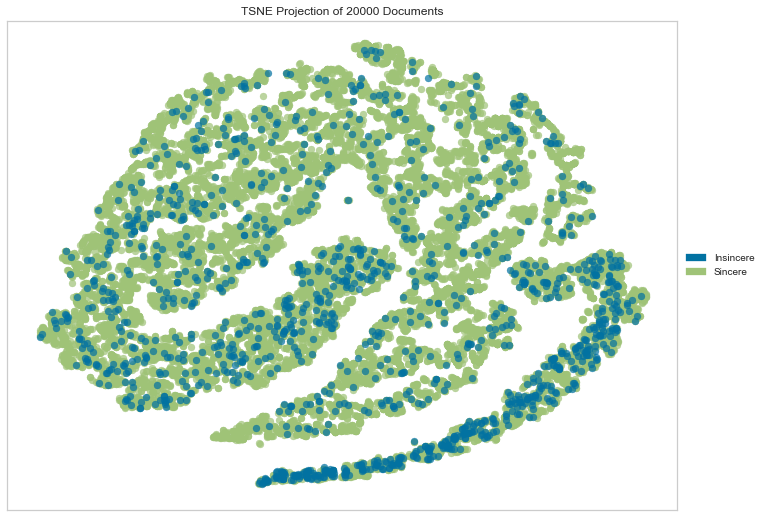

In [11]:
# Create the visualizer and draw the vectors
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
n = 20000
tsne.fit(X[:n], train.target[:n].map({1: target_names[1],0:target_names[0]}))
tsne.poof()

### Light Gradient Boosting Binary Classifier

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

evals_result = {}  # to record eval results for plotting
print("Light Gradient Boosting Classifier: ")

modelstart= time.time()
# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names)

Light Gradient Boosting Classifier: 


Let's try automated hyperparameter tuning with [**hyperopt**](https://github.com/hyperopt/hyperopt).

_Hyperopt is an open-source Python library the implements Bayesian Optimization using the Tree Parzen Estimator algorithm to construct the surrogate function and select the next hyperparameter values to evaluate in the objective function. There are a number of other libraries such as Spearmint (Guassian process surrogate function) and SMAC (random forest regression surrogate function) sharing the same problem structure. The four parts of an optimization problem that we develop here will apply to all the libraries with only a change in syntax. Morevoer, the optimization methods as applied to the Gradient Boosting Machine will translate to other machine learning models or any problem where we have to minimize a function._

## Optimization Algorithm

In [13]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import Trials
from hyperopt import fmin

In [14]:
# LGBM parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# Description: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             ]),
    'num_leaves': hp.quniform('num_leaves', 27, 32, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'feature_fraction': hp.loguniform('feature_fraction', np.log(0.7), np.log(0.9)),
    'bagging_fraction': hp.loguniform('bagging_fraction', np.log(0.7), np.log(0.9)),
    'min_split_gain': hp.loguniform('min_split_gain', np.log(0.05), np.log(.1)),
    # 'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 10, 20, 5),
    # 'max_depth': hp.quniform('max_depth', 8, 10, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
#     'is_unbalance': True,
}

Parameters description

- num_leaves: number of leaves in full tree, default: 31

- learning_rate: _determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…_

- feature_fraction: _ Used when your boosting(discussed later) is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees._

- bagging_fraction: _specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting._

- min_child_samples: minimal number of data in one leaf. Can be used to deal with over-fitting

- min_split_gain: the minimal gain to perform split (???)

- reg_alpha: L1 regularization (https://en.wikipedia.org/wiki/Regularization_(mathematics))

- reg_lambda: L2 regularization

In [15]:
# Sample from the full space
x = sample(space)

# # Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'bagging_fraction': 0.8254258849276236,
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.6849024007710918,
 'feature_fraction': 0.7889536919858555,
 'learning_rate': 0.0024014811599866208,
 'min_child_samples': 20.0,
 'min_split_gain': 0.06839478701355907,
 'num_leaves': 29.0,
 'reg_alpha': 0.3841721838206412,
 'reg_lambda': 0.042350543498882565,
 'subsample': 0.6724679276774419}

In [16]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [17]:
# Record results
trials = Trials()

In [18]:
# import csv
# from hyperopt import STATUS_OK
# from timeit import default_timer as timer

# N_FOLDS = 5
# MAX_EVALS = 5

# def objective(hyperparameters):
#     """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
#        Writes a new line to `outfile` on every iteration"""
    
#     # Keep track of evals
#     global ITERATION
    
#     ITERATION += 1
    
#     # Using early stopping to find number of trees trained
#     if 'n_estimators' in hyperparameters:
#         del hyperparameters['n_estimators']
    
#     # Retrieve the subsample
#     subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
#     # Extract the boosting type and subsample to top level keys
#     hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
#     hyperparameters['subsample'] = subsample
    
#     # Make sure parameters that need to be integers are integers
#     for parameter_name in ['num_leaves', 'min_child_samples']:
#         hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

#     start = timer()
    
#     # Perform n_folds cross validation
#     cv_results = lgb.cv(hyperparameters, lgtrain, num_boost_round = 10000, nfold = N_FOLDS, 
#                         early_stopping_rounds = 100, metrics = 'auc', seed = 50)

#     run_time = timer() - start
    
#     # Extract the best score
#     best_score = cv_results['auc-mean'][-1]
    
#     # Loss must be minimized
#     loss = 1 - best_score
    
#     # Boosting rounds that returned the highest cv score
#     n_estimators = len(cv_results['auc-mean'])
    
#     # Add the number of estimators to the hyperparameters
#     hyperparameters['n_estimators'] = n_estimators

#     # Write to the csv file ('a' means append)
#     of_connection = open(OUT_FILE, 'a')
#     writer = csv.writer(of_connection)
#     writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
#     of_connection.close()

#     # Dictionary with information for evaluation
#     return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
#             'train_time': run_time, 'status': STATUS_OK}

In [19]:
lgbm_params = {
        "objective": "binary",
        'metric': {'auc'},
        "boosting_type": "gbdt",
        "num_threads": 4,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "min_split_gain": .1,
        "reg_alpha": .1,
        'verbose': -1,
    }

In [20]:
# # Create a file and open a connection
# OUT_FILE = 'bayes_test.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# ITERATION = 0

# # Write column names
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

## Automated Hyperparameter Optimization in Practice

In [21]:
# # Global variable
# global  ITERATION

# ITERATION = 0

# # Run optimization
# best = fmin(fn = objective, 
#             space = space, 
#             algo = tpe.suggest, 
#             trials = trials,
#             max_evals = MAX_EVALS)

# best

In [22]:
# # Sort the trials with lowest loss (highest AUC) first
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])
# trials_dict[:1]

In [23]:
# results = pd.read_csv(OUT_FILE)

In [24]:
# import ast

# def evaluate(results, name):
#     """Evaluate model on test data using hyperparameters in results
#        Return dataframe of hyperparameters"""
    
#     new_results = results.copy()
#     # String to dictionary
#     new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
#     # Sort with best values on top
#     new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
#     # Print out cross validation high score
#     print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
#     # Use best hyperparameters to create a model
#     hyperparameters = new_results.loc[0, 'hyperparameters']
#     model = lgb.LGBMClassifier(**hyperparameters)
    
#     # Train and make predictions
#     model.fit(train_features, train_labels)
#     preds = model.predict_proba(test_features)[:, 1]
    
#     print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
#     # Create dataframe of hyperparameters
#     hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

#     # Iterate through each set of hyperparameters that were evaluated
#     for i, hyp in enumerate(new_results['hyperparameters']):
#         hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
#                                ignore_index = True)
        
#     # Put the iteration and score in the hyperparameter dataframe
#     hyp_df['iteration'] = new_results['iteration']
#     hyp_df['score'] = new_results['score']
    
#     return hyp_df
# bayes_results = evaluate(results, name = 'Bayesian')
# bayes_results

In [25]:
# bayes_results = evaluate(results, name = 'Bayesian')
# bayes_results

## Continue optimization

In [26]:
# MAX_EVALS = 10

# # Continue training
# best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
#             max_evals = MAX_EVALS)

In [27]:
# import json

# # Save the trial results
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

In [28]:
# Go Go Go
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round= max_boosting_rounds,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=150,
    evals_result=evals_result,
    verbose_eval=100
)

del lgtrain, lgvalid

gc.collect()

Training until validation scores don't improve for 150 rounds.
[100]	train's auc: 0.98632	valid's auc: 0.911385
[200]	train's auc: 0.997238	valid's auc: 0.915486
[300]	train's auc: 0.999618	valid's auc: 0.915476
Early stopping, best iteration is:
[222]	train's auc: 0.998143	valid's auc: 0.916151


25

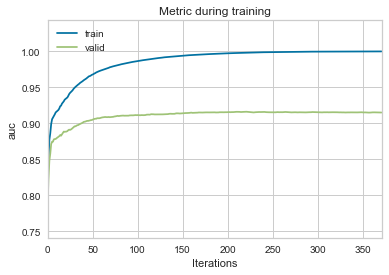

In [31]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [32]:
valid_pred = lgb_clf.predict(X_valid)
_thresh = []
for thresh in np.arange(0.1, 0.501, 0.01):
    _thresh.append([thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))])
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))))

_thresh = np.array(_thresh)
best_id = _thresh[:,1].argmax()
best_thresh = _thresh[best_id][0]
print("Best Threshold: {}\nF1 Score: {}".format(best_thresh, _thresh[best_id][1]))

Best Threshold: 0.2899999999999999
F1 Score: 0.5592105263157895


### Seed Diversification

In [33]:
allmodelstart= time.time()
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

optimal_rounds = lgb_clf.best_iteration

lgtrain = lgb.Dataset(X, y, feature_name=feature_names)

all_seeds = [27,22]
for seeds_x in all_seeds:
    modelstart= time.time()
    print("Seed: ", seeds_x,)
    # Go Go Go
    lgbm_params["seed"] = seeds_x
    lgb_seed_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_names
    fold_importance_df["importance"] = lgb_seed_clf.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  list(lgb_seed_clf.predict(testing))
    print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
    print("###########################################################################################")
    del lgb_seed_clf
    
del lgtrain, X

Seed:  27
Model Runtime: 0.34 Minutes
###########################################################################################
Seed:  22
Model Runtime: 0.32 Minutes
###########################################################################################


**Model Evaluation**

/l/musaevm1/anaconda3/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



All Model Runtime: 0.68 Minutes


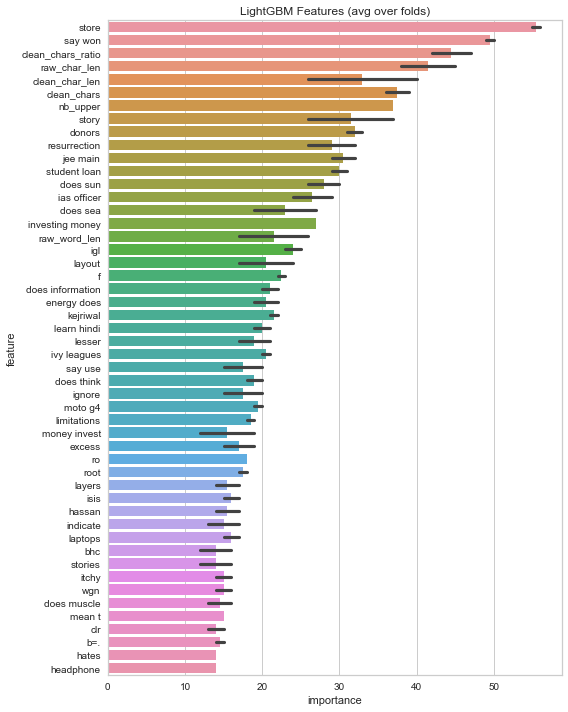

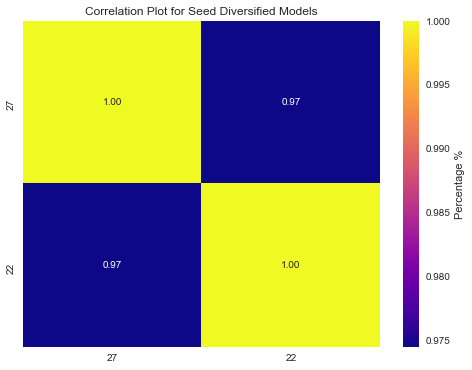

In [34]:
cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
print("All Model Runtime: %0.2f Minutes"%((time.time() - allmodelstart)/60))

# To DataFrame
sub_preds = pd.DataFrame.from_dict(multi_seed_pred).replace(0,0.000001)
del multi_seed_pred; gc.collect();

# Correlation Plot
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(sub_preds.corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Correlation Plot for Seed Diversified Models")
plt.show()

**Submit**

In [35]:
# Take Mean over Seed prediction
target_var = 'prediction'
mean_sub = sub_preds.mean(axis=1).rename(target_var)
mean_sub = (mean_sub > best_thresh).astype(int)
mean_sub.index = testdex

# Submit
mean_sub.to_csv('submission.csv',index = True, header=True)
print(mean_sub.value_counts(normalize=True))
mean_sub.head()

0    0.9446
1    0.0554
Name: prediction, dtype: float64


qid
8c452bcc110c8ac70935    0
cf4d93c0fcde9273c37d    0
67a44950d7e11dfa9ae6    0
506bb8ea1284e19d3641    0
17d0e27237580a02c193    0
Name: prediction, dtype: int64

## References